In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from scipy.stats import spearmanr
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import pickle


In [3]:
motif_features = pd.read_excel("/home/ioannis/thesis_data/ML/motif_features_ML.xlsx")
print(motif_features.head())

  motif_id     intra     inter  mcs_size  mcs_support  n_peaks  n_spectra  \
0   91_400  0.015868  0.344764         7     0.554217        1         83   
1   38_400  0.051209  0.500000         6     0.763158        2         38   
2   43_400  0.577539  0.415385        13     0.753333        1        150   
3  176_400  0.020690  0.322222         7     0.733333        1         30   
4  153_400  0.730739  0.630657        31     0.535519        2        183   

   peak_mean  peak_std  peak_min  peak_max  label  
0   0.927711  0.000000  0.927711  0.927711    0.9  
1   0.723684  0.065789  0.657895  0.789474    0.5  
2   0.873333  0.000000  0.873333  0.873333    0.9  
3   0.700000  0.000000  0.700000  0.700000    0.5  
4   0.483607  0.303279  0.180328  0.786885    0.5  


In [4]:
X = motif_features.drop(columns=['motif_id', 'label'])
y = motif_features['label']

In [5]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
y_strat = motif_features["label"].astype(str)   # used only for stratification


In [9]:
spearman_scores = []
mae_scores = []

all_true = []
all_pred = []
all_ids = []

for train_idx, test_idx in skf.split(X, y_strat):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    model = RandomForestRegressor(
        n_estimators=500,
        random_state=42
    )

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # store predictions for plotting later
    all_true.extend(y_test)
    all_pred.extend(y_pred)

    # ranking metric
    spearman = spearmanr(y_test, y_pred).correlation
    spearman_scores.append(spearman)

    # regression metric
    mae = mean_absolute_error(y_test, y_pred)
    mae_scores.append(mae)

    # store motif IDs for the test fold
    motif_ids_test = motif_features.iloc[test_idx]["motif_id"]
    all_ids.extend(motif_ids_test)


In [11]:
print("Spearman correlation per fold:", spearman_scores)
print("Mean Spearman:", np.mean(spearman_scores))

print("\nMAE per fold:", mae_scores)
print("Mean MAE:", np.mean(mae_scores))

Spearman correlation per fold: [0.8626053049268316, 0.9198662110077999, 0.9031413708076581, 0.7406714945777089, 0.9302605094190635]
Mean Spearman: 0.8713089781478125

MAE per fold: [0.14245714285714323, 0.08314285714285775, 0.13885714285714307, 0.1626285714285714, 0.10640000000000084]
Mean MAE: 0.12669714285714326


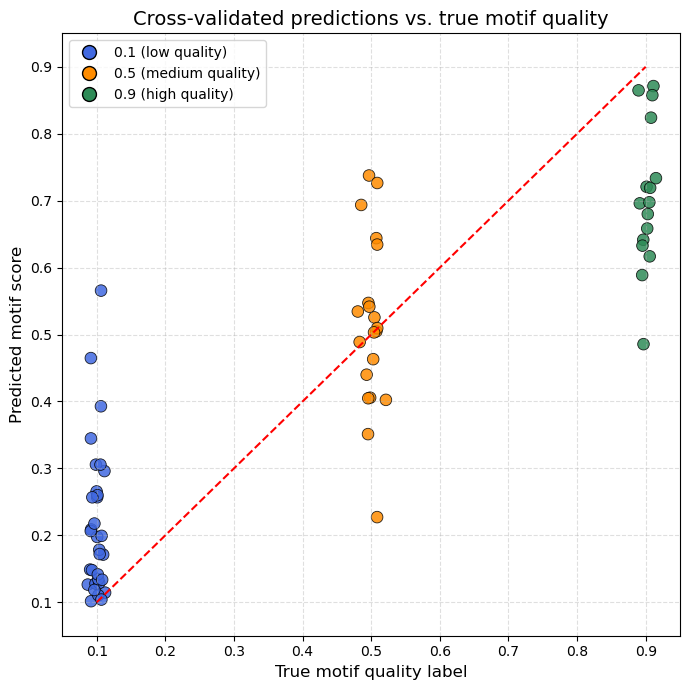

In [12]:
# Convert to arrays
true_vals = np.array(all_true)
pred_vals = np.array(all_pred)

# Add small jitter to x-axis (true labels)
rng = np.random.default_rng(42)
x_jittered = true_vals + rng.normal(0, 0.01, size=len(true_vals))

# Color map for classes
colors = {0.1: "royalblue", 0.5: "darkorange", 0.9: "seagreen"}
point_colors = [colors[val] for val in true_vals]

plt.figure(figsize=(7,7))

# Scatter plot
plt.scatter(
    x_jittered,
    pred_vals,
    c=point_colors,
    alpha=0.85,
    edgecolor="black",
    linewidth=0.6,
    s=70
)

# Diagonal reference line
plt.plot([0.1, 0.9], [0.1, 0.9], "r--", linewidth=1.5)

# Labels and title
plt.xlabel("True motif quality label", fontsize=12)
plt.ylabel("Predicted motif score", fontsize=12)
plt.title("Cross‑validated predictions vs. true motif quality", fontsize=14)

# Grid and limits
plt.grid(True, linestyle="--", alpha=0.4)
plt.xlim(0.05, 0.95)
plt.ylim(0.05, 0.95)

# Legend
legend_elements = [
    Line2D([0], [0], marker='o', color='w', label='0.1 (low quality)',
           markerfacecolor='royalblue', markersize=10, markeredgecolor='black'),
    Line2D([0], [0], marker='o', color='w', label='0.5 (medium quality)',
           markerfacecolor='darkorange', markersize=10, markeredgecolor='black'),
    Line2D([0], [0], marker='o', color='w', label='0.9 (high quality)',
           markerfacecolor='seagreen', markersize=10, markeredgecolor='black')
]
plt.legend(handles=legend_elements, loc="upper left", frameon=True)

plt.tight_layout()
plt.show()


In [13]:
results_df = pd.DataFrame({
    "motif_id": all_ids,
    "true_label": all_true,
    "predicted_score": all_pred
}).sort_values("predicted_score", ascending=False)
results_df
results_df.to_excel("cv_predictions_with_ids_final.xlsx", index=False)

In [14]:
from sklearn.ensemble import RandomForestRegressor

final_model = RandomForestRegressor(
    n_estimators=500,
    random_state=42
)

final_model.fit(X, y)

,n_estimators,500
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [15]:
importances = final_model.feature_importances_
feature_names = X.columns

for name, imp in sorted(zip(feature_names, importances), key=lambda x: -x[1]):
    print(f"{name}: {imp:.3f}")

peak_max: 0.293
mcs_support: 0.212
mcs_size: 0.148
peak_mean: 0.127
intra: 0.081
n_spectra: 0.054
peak_min: 0.032
n_peaks: 0.020
inter: 0.018
peak_std: 0.015


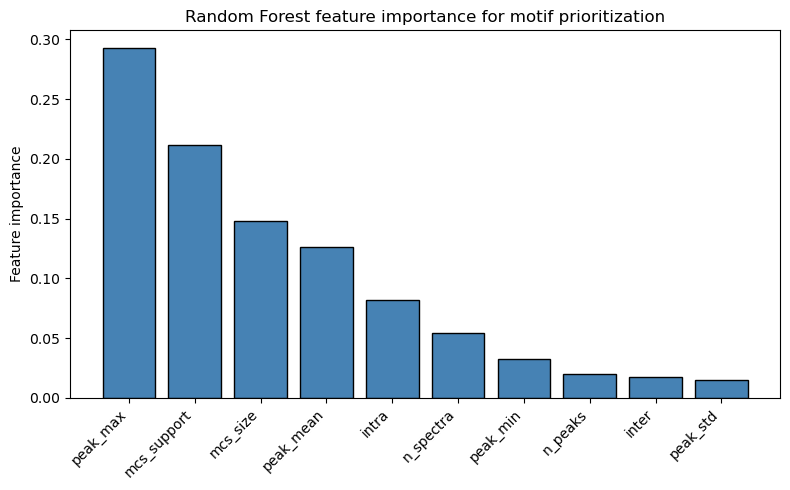

In [16]:
import matplotlib.pyplot as plt
import numpy as np

# Sort features by importance
indices = np.argsort(importances)[::-1]
sorted_names = feature_names[indices]
sorted_importances = importances[indices]

plt.figure(figsize=(8,5))
plt.bar(range(len(sorted_importances)), sorted_importances,
        color="steelblue", edgecolor="black")
plt.xticks(range(len(sorted_importances)), sorted_names,
           rotation=45, ha="right")
plt.ylabel("Feature importance")
plt.title("Random Forest feature importance for motif prioritization")
plt.tight_layout()
plt.show()


In [51]:
with open("motif_priority_model.pkl", "wb") as f:
    pickle.dump(final_model, f)